In [59]:
import numpy as np
from pyomo.environ import *
from pyomo.opt import SolverFactory

# ------------------ Constants ------------------ #
Load = np.array([88.24, 83.01, 80.15, 79.01, 76.07, 78.39, 89.95, 128.85, 155.45, 176.35,
                 193.71, 182.57, 179.64, 166.31, 164.61, 164.61, 174.48, 203.93, 218.99, 238.11,
                 216.14, 173.87, 131.07, 94.04])
Pw = np.array([66.9, 68.2, 71.9, 72, 78.8, 94.8, 114.3, 145.1, 155.5, 142.1,
               115.9, 127.1, 141.8, 145.6, 145.3, 150, 206.9, 225.5, 236.1, 210.8,
               198.6, 177.9, 147.2, 58.7])
Ppv = np.array([0, 0, 0, 0, 0.06, 6.54, 20.19, 39.61, 49.64, 88.62,
                101.59, 66.78, 110.46, 67.41, 31.53, 50.76, 20.6, 22.08, 2.07, 0,
                0, 0, 0, 0])
C_buy = np.array([0.25]*7 + [0.53]*3 + [0.82]*5 + [0.53]*3 + [0.82]*3 + [0.53]*3)
C_sell = np.array([0.22]*7 + [0.42]*3 + [0.65]*5 + [0.42]*3 + [0.65]*3 + [0.42]*3)

Ebattery = 300
soc0 = 0.5
socmin = 0.3
socmax = 0.95
Pcs = 40
POWER = 160
T = range(24)

Pwc = 0.52  # Cost coefficient for wind power output 
Ppvc = 0.72 # Cost coefficient for solar power output 
Pdisc = 0.2 # Cost coefficient per kWh of battery discharge power 

# ------------------ Pyomo Model ------------------ #
model = ConcreteModel()

# Variables
model.Pbuy = Var(T, bounds=(0, POWER))         # Power bought from grid (positive)
model.Psell = Var(T, bounds=(-POWER, 0))       # Power sold to grid (negative)
model.Pcha = Var(T, bounds=(0, Pcs))           # Battery charging power (positive)
model.Pdis = Var(T, bounds=(-Pcs, 0))          # Battery discharging power (negative)

model.Pnet = Var(T)                             # Net grid power: Pbuy + Psell
model.Pbat = Var(T)                             # Battery net power: Pcha + Pdis
model.SOC = Var(T, bounds=(Ebattery * socmin, Ebattery * socmax))  # State of charge

# Binary variables for exclusivity
model.Temp_net = Var(T, within=Binary)         # 1 = buying, 0 = selling
model.Temp_cha = Var(T, within=Binary)         # 1 = charging
model.Temp_dis = Var(T, within=Binary)         # 1 = discharging
model.Temp_static = Var(T, within=Binary)      # 1 = idle

model.constraints = ConstraintList()

for t in T:
    # Net grid power relation
    model.constraints.add(model.Pnet[t] == model.Pbuy[t] + model.Psell[t])
    
    # Battery net power relation
    model.constraints.add(model.Pbat[t] == model.Pcha[t] + model.Pdis[t])
    
    # Power balance: Grid + Wind + PV = Load + Battery
    model.constraints.add(model.Pnet[t] + Pw[t] + Ppv[t] == Load[t] + model.Pbat[t])
    
    # Grid exclusivity constraints
    model.constraints.add(model.Pbuy[t] <= POWER * model.Temp_net[t])
    model.constraints.add(model.Psell[t] >= -POWER * (1 - model.Temp_net[t]))
    model.constraints.add(model.Pbuy[t] >= 0)
    model.constraints.add(model.Psell[t] <= 0)
    
    # Battery exclusivity constraints
    model.constraints.add(model.Pcha[t] <= Pcs * model.Temp_cha[t])
    model.constraints.add(model.Pdis[t] >= -Pcs * model.Temp_dis[t])
    model.constraints.add(model.Temp_cha[t] + model.Temp_dis[t] + model.Temp_static[t] == 1)

# Initial SOC equals initial condition
model.constraints.add(model.SOC[0] == Ebattery * soc0)

# SOC update for t>0
for t in range(1, 24):
    model.constraints.add(model.SOC[t] == model.SOC[t-1] + model.Pcha[t-1] + model.Pdis[t-1])

# Final SOC equals initial SOC
model.constraints.add(model.SOC[23] == Ebattery * soc0)

# Objective function
model.obj = Objective(
    expr=sum(
        Pwc * Pw[t] + Ppvc * Ppv[t] + 
        C_buy[t] * model.Pbuy[t] +
        C_sell[t] * model.Psell[t] +
        Pdisc * (-model.Pdis[t])  # discharge cost, Pdis negative
        for t in T),
    sense=minimize
)

# Solve
solver = SolverFactory('cplex')
results = solver.solve(model, tee=True)

# ------------------ Results ------------------ #
Pbuy = np.array([value(model.Pbuy[t]) for t in T])
Psell = np.array([value(model.Psell[t]) for t in T])
Pcha = np.array([value(model.Pcha[t]) for t in T])
Pdis = np.array([value(model.Pdis[t]) for t in T])
Pnet = np.array([value(model.Pnet[t]) for t in T])
Pbat = np.array([value(model.Pbat[t]) for t in T])
SOC = np.array([value(model.SOC[t]) / Ebattery for t in T])

# Optional: print results for quick check
print("Pbuy:", Pbuy)
print("Psell:", Psell)
print("Pcha:", Pcha)
print("Pdis:", Pdis)
print("SOC:", SOC)

# You can add your plotting code here as needed



Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer Community Edition 22.1.1.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2022.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile '/var/folders/_h/p3q8xmcx6xgfs0sfkv3_p7cw0000gn/T/tmpl5pzcgkd.cplex.log' open.
CPLEX> Problem '/var/folders/_h/p3q8xmcx6xgfs0sfkv3_p7cw0000gn/T/tmpo97mthsp.pyomo.lp' read.
Read time = 0.00 sec. (0.02 ticks)
CPLEX> Problem name         : /var/folders/_h/p3q8xmcx6xgfs0sfkv3_p7cw0000gn/T/tmpo97mthsp.pyomo.lp
Objective sense      : Minimize
Variables            :     265  [Fix: 1,  Box: 120,  Free: 48,  Binary: 96]
Objective nonzeros   :      73
Linear constraints   :     265  [Less: 120,  Greater: 24,  Equal: 121]
  Nonzeros           :     598
  RHS nonzeros       :      74

Var

In [66]:
# Compute and print total cost
total_cost = sum(
    Pwc * Pw[t] + Ppvc * Ppv[t] + 
    C_buy[t] * Pbuy[t] + 
    C_sell[t] * Psell[t] + 
    Pdisc * (-Pdis[t])
    for t in T
)
print(f"Total cost = {total_cost:.4f}")


# No battery, no grid interaction
Pbuy_noopt = np.zeros(24)
Psell_noopt = np.zeros(24)
Pcha_noopt = np.zeros(24)
Pdis_noopt = np.zeros(24)

# Calculate total cost without optimization:
total_cost_noopt = sum(
    Pwc * Pw[t] + Ppvc * Ppv[t] + 
    C_buy[t] * Pbuy_noopt[t] + 
    C_sell[t] * Psell_noopt[t] + 
    Pdisc * (-Pdis_noopt[t])  # zero anyway
    for t in range(24)
)

print(f"Total cost without optimization = {total_cost_noopt:.4f}")


Total cost = 1949.8870
Total cost without optimization = 2202.5568


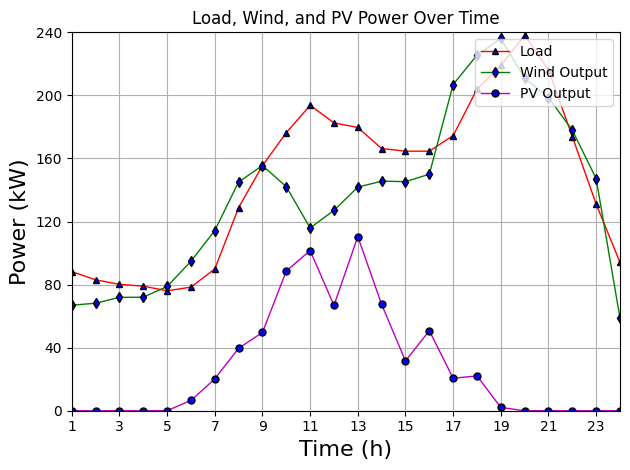

In [60]:
import matplotlib.pyplot as plt
import numpy as np


# Plot
x = np.arange(1, 25)

# ---------- Plot 1: Load, Wind, PV ----------
plt.figure()
plt.plot(x, Load, '-r^', label='Load', linewidth=1, markeredgecolor='k', markerfacecolor='blue', markersize=5)
plt.plot(x, Pw, '-gd', label='Wind Output', linewidth=1, markeredgecolor='k', markerfacecolor='blue', markersize=5)
plt.plot(x, Ppv, '-mo', label='PV Output', linewidth=1, markeredgecolor='k', markerfacecolor='blue', markersize=5)
plt.axis([1, 24, 0, 240])
plt.xlabel('Time (h)', fontsize=16)
plt.ylabel('Power (kW)', fontsize=16)
plt.xticks(np.arange(1, 25, 2))
plt.yticks(np.arange(0, 241, 40))
plt.title("Load, Wind, and PV Power Over Time")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()





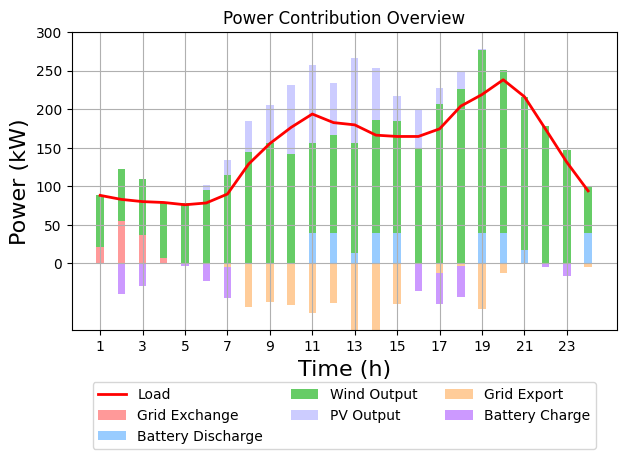

In [61]:
# ---------- Plot 2: Stacked Bar for Power Components ----------
fig, ax = plt.subplots()
bar_width = 0.35

bottom_pos = np.zeros(24)
colors_pos = ['#ff9999', '#99ccff', '#66cc66', '#ccccff']
labels_pos = ['Grid Exchange', 'Battery Discharge', 'Wind Output', 'PV Output']
stack_data_pos = [Pbuy, -Pdis, Pw, Ppv]

for i, data in enumerate(stack_data_pos):
    ax.bar(x, data, bar_width, bottom=bottom_pos, label=labels_pos[i], color=colors_pos[i])
    bottom_pos += data

# Overlay negative stack
bottom_neg = np.zeros(24)
stack_data_neg = [Psell, -Pcha]
colors_neg = ['#ffcc99', '#cc99ff']
labels_neg = ['Grid Export', 'Battery Charge']

for i, data in enumerate(stack_data_neg):
    ax.bar(x, data, bar_width, bottom=bottom_neg, label=labels_neg[i], color=colors_neg[i])
    bottom_neg += data

# Overlay load curve
ax.plot(x, Load, 'r-', linewidth=2, label='Load')

ax.set_xlabel('Time (h)', fontsize=16)
ax.set_ylabel('Power (kW)', fontsize=16)
ax.set_xticks(np.arange(1, 25, 2))
ax.set_yticks(np.arange(0, 301, 50))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
ax.set_title('Power Contribution Overview')
ax.grid(True)
plt.tight_layout()
plt.show()



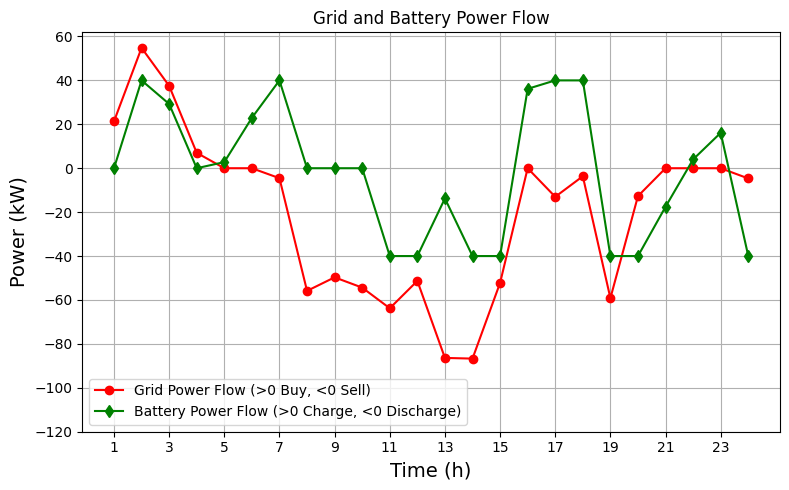

In [62]:
# Plot 2: Grid and Battery Power Flow over time
plt.figure(figsize=(8,5))
plt.plot(x, Pbuy + Psell, 'ro-', label='Grid Power Flow (>0 Buy, <0 Sell)')
plt.plot(x, Pcha + Pdis, 'gd-', label='Battery Power Flow (>0 Charge, <0 Discharge)')
plt.xlabel('Time (h)', fontsize=14)
plt.ylabel('Power (kW)', fontsize=14)
plt.xticks(np.arange(1, 25, 2))
plt.yticks(np.arange(-120, 80, 20))
plt.legend(loc='best')
plt.title('Grid and Battery Power Flow')
plt.grid(True)
plt.tight_layout()
plt.show()



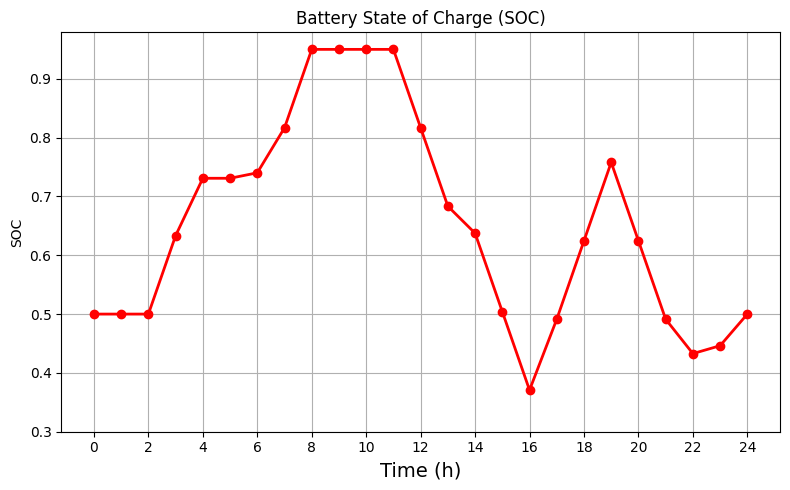

In [63]:
# Plot 3: Battery SOC over time
plt.figure(figsize=(8,5))
xx = np.arange(0, 25)
soc_full = np.zeros(25)
soc_full[0] = soc0
soc_full[1:] = SOC

plt.plot(xx, soc_full, 'ro-', linewidth=2, label='Battery SOC')
plt.xlabel('Time (h)', fontsize=14)
plt.ylabel('SOC')
plt.xticks(np.arange(0, 25, 2))
plt.yticks(np.arange(socmin, socmax + 0.05, 0.1))
plt.title('Battery State of Charge (SOC)')
plt.grid(True)
plt.tight_layout()
plt.show()